In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from pandas.api.types import CategoricalDtype

In [2]:
final_df = pd.read_csv('D:/DO_NOT_REMOVE/Data_Analyst_Junior/7_11/Данные для кейса/funnel_info.csv')
final_df.shape

(3845707, 7)

### Пропуски

In [3]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3845707 entries, 0 to 3845706
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   user_id       int64  
 1   funnel_stage  object 
 2   timestamp     int64  
 3   profit        float64
 4   os            object 
 5   ad_channel    object 
 6   price         float64
dtypes: float64(2), int64(2), object(3)
memory usage: 205.4+ MB


<Axes: >

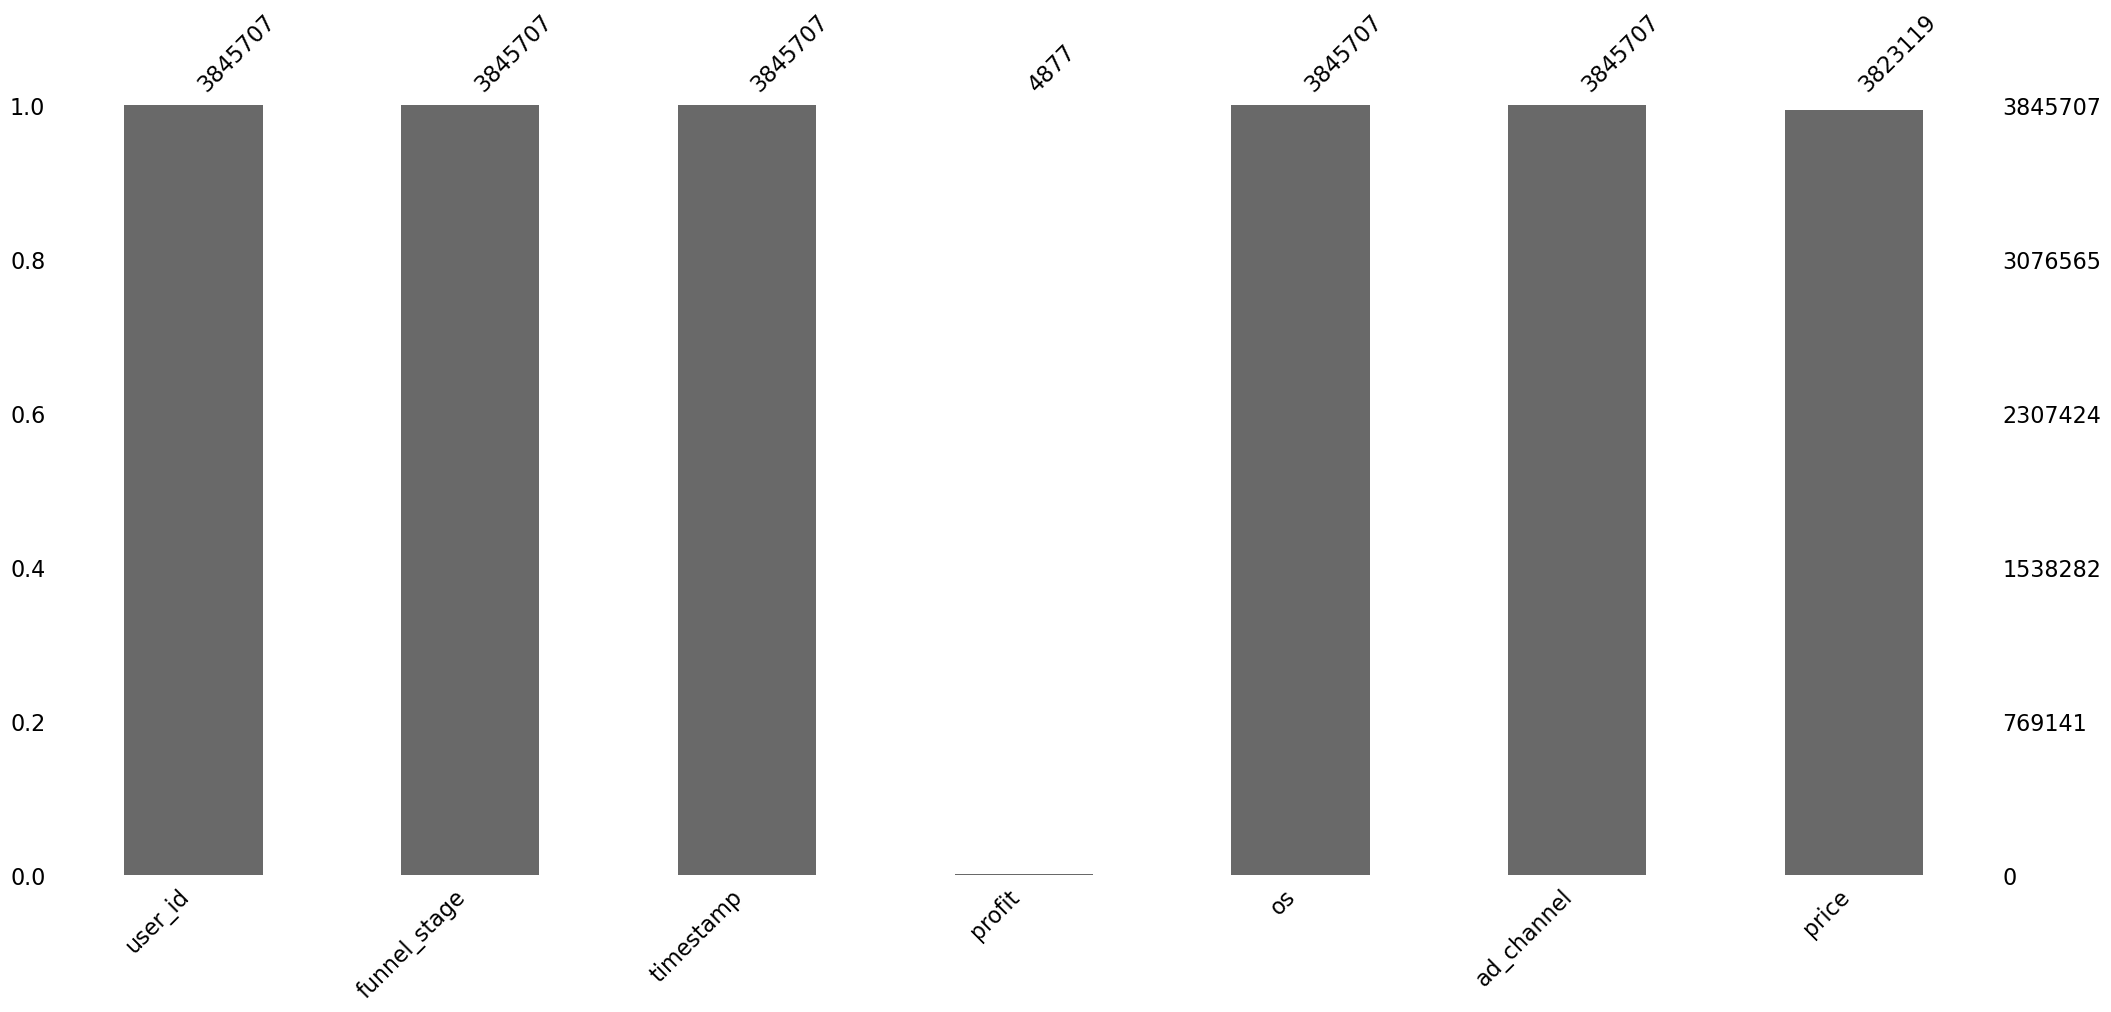

In [4]:
msno.bar(final_df)

In [5]:
final_df.isna().sum()

user_id               0
funnel_stage          0
timestamp             0
profit          3840830
os                    0
ad_channel            0
price             22588
dtype: int64

In [8]:
final_df[~final_df.profit.isna()]

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
1,720354,purchase,225495,50.0,Android,organic_traffic,0.0
5,749577,PURCHASE,224647,2136.0,iOS,search,1.5
9,104960,purchase,223361,520.0,iOS,organic_traffic,0.0
15,750226,purchase,222773,260.0,Android,organic_traffic,0.0
16,152432,PURCHASE,222568,2136.0,Android,search,1.5
...,...,...,...,...,...,...,...
3841432,962335,PURCHASE,150117,2136.0,iOS,search,1.5
3844208,638226,PURCHASE,150072,1099.0,iOS,search,1.5
3844368,727830,PURCHASE,150059,1099.0,Android,search,1.5
3844877,941001,PURCHASE,150029,520.0,iOS,search,1.5


#### Заполняем пропуски по 'price'

In [9]:
df1 = final_df[final_df['price'].isna()]

In [10]:
df1['ad_channel'].unique()

array(['other'], dtype=object)

In [11]:
#Заменяем значение NaN в столбце 'price' на 0
final_df.loc[final_df['ad_channel']=="other", 'price'] = 0

<Axes: >

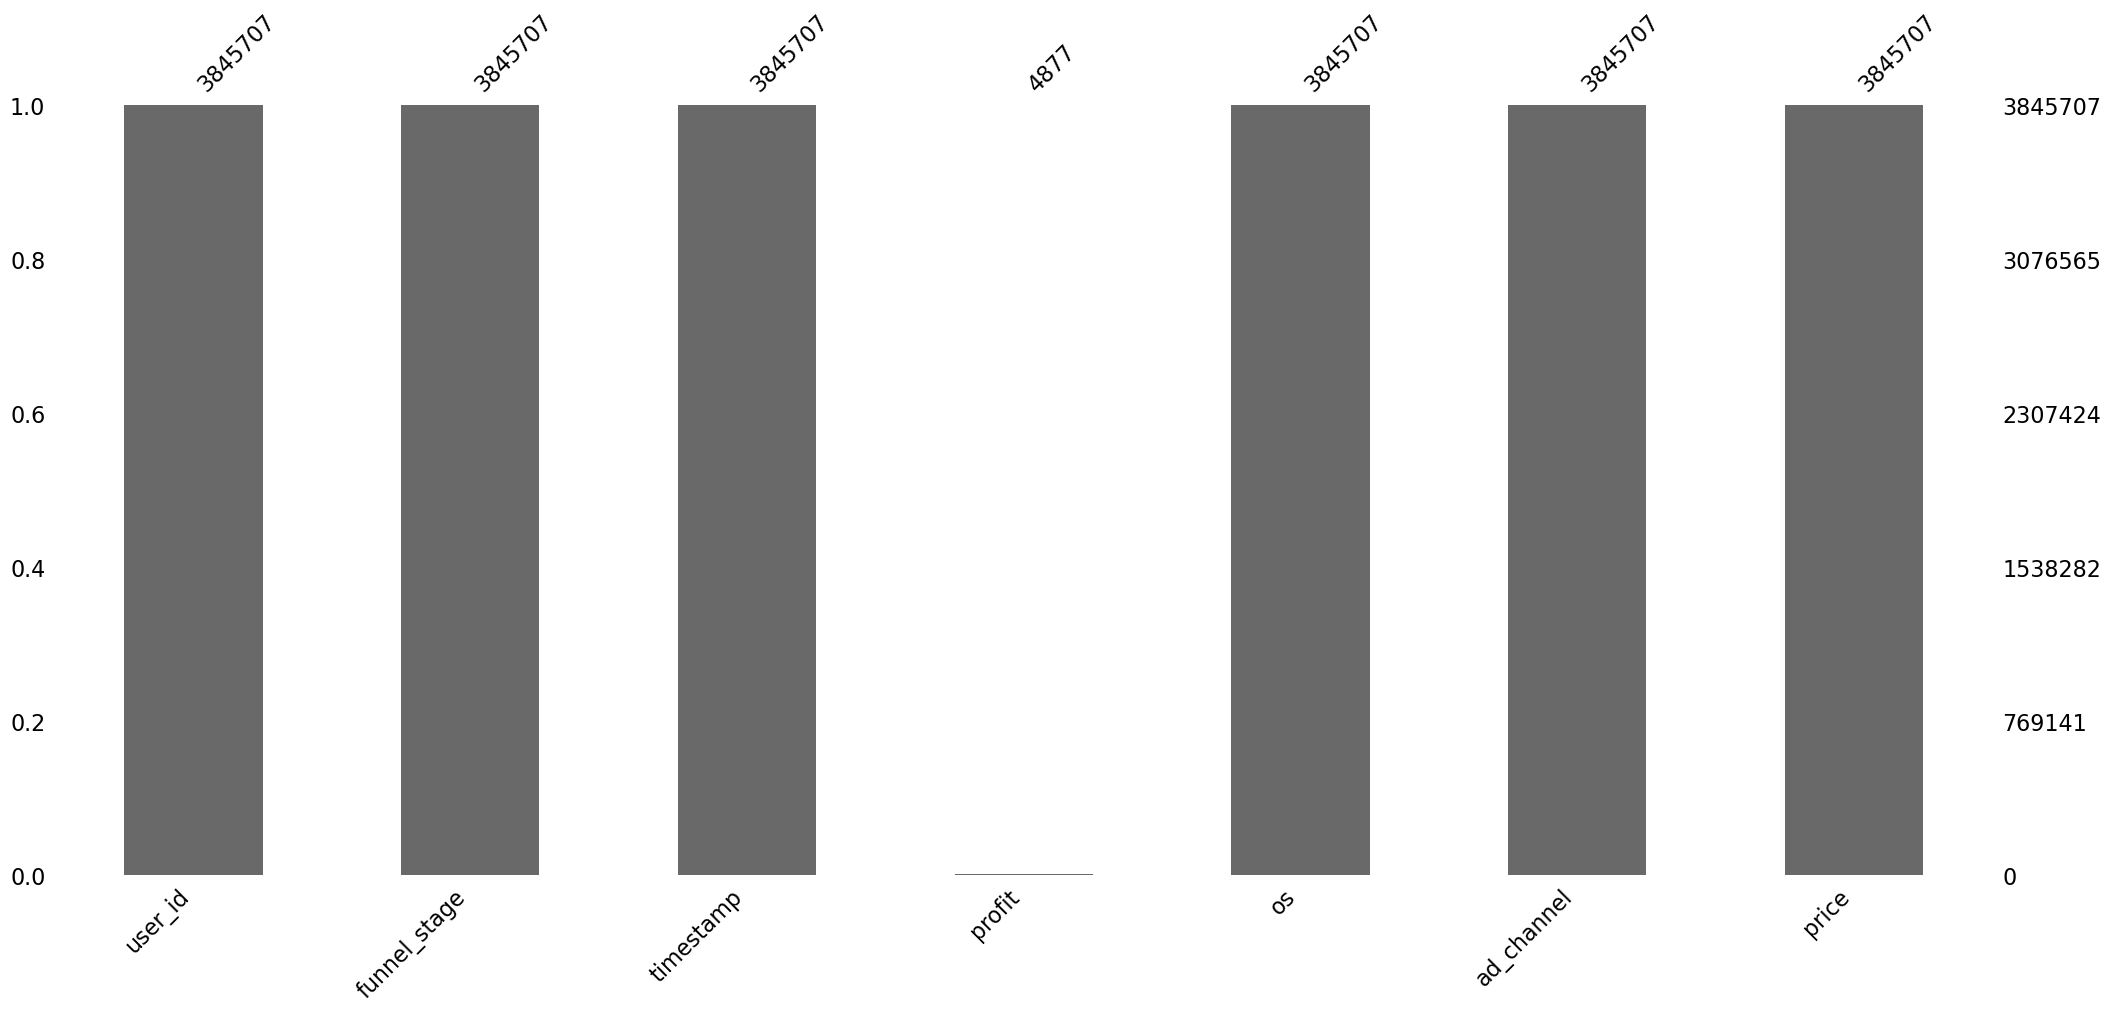

In [12]:
msno.bar(final_df)

#### Заполняем пропуски по 'profit'

In [13]:
df2 = final_df[final_df['profit'].isna()]
df2.shape

(3840830, 7)

In [14]:
#Заменяем значение NaN в столбце 'profit' на 0
final_df.loc[final_df['profit'].isna(), 'profit'] = 0

<Axes: >

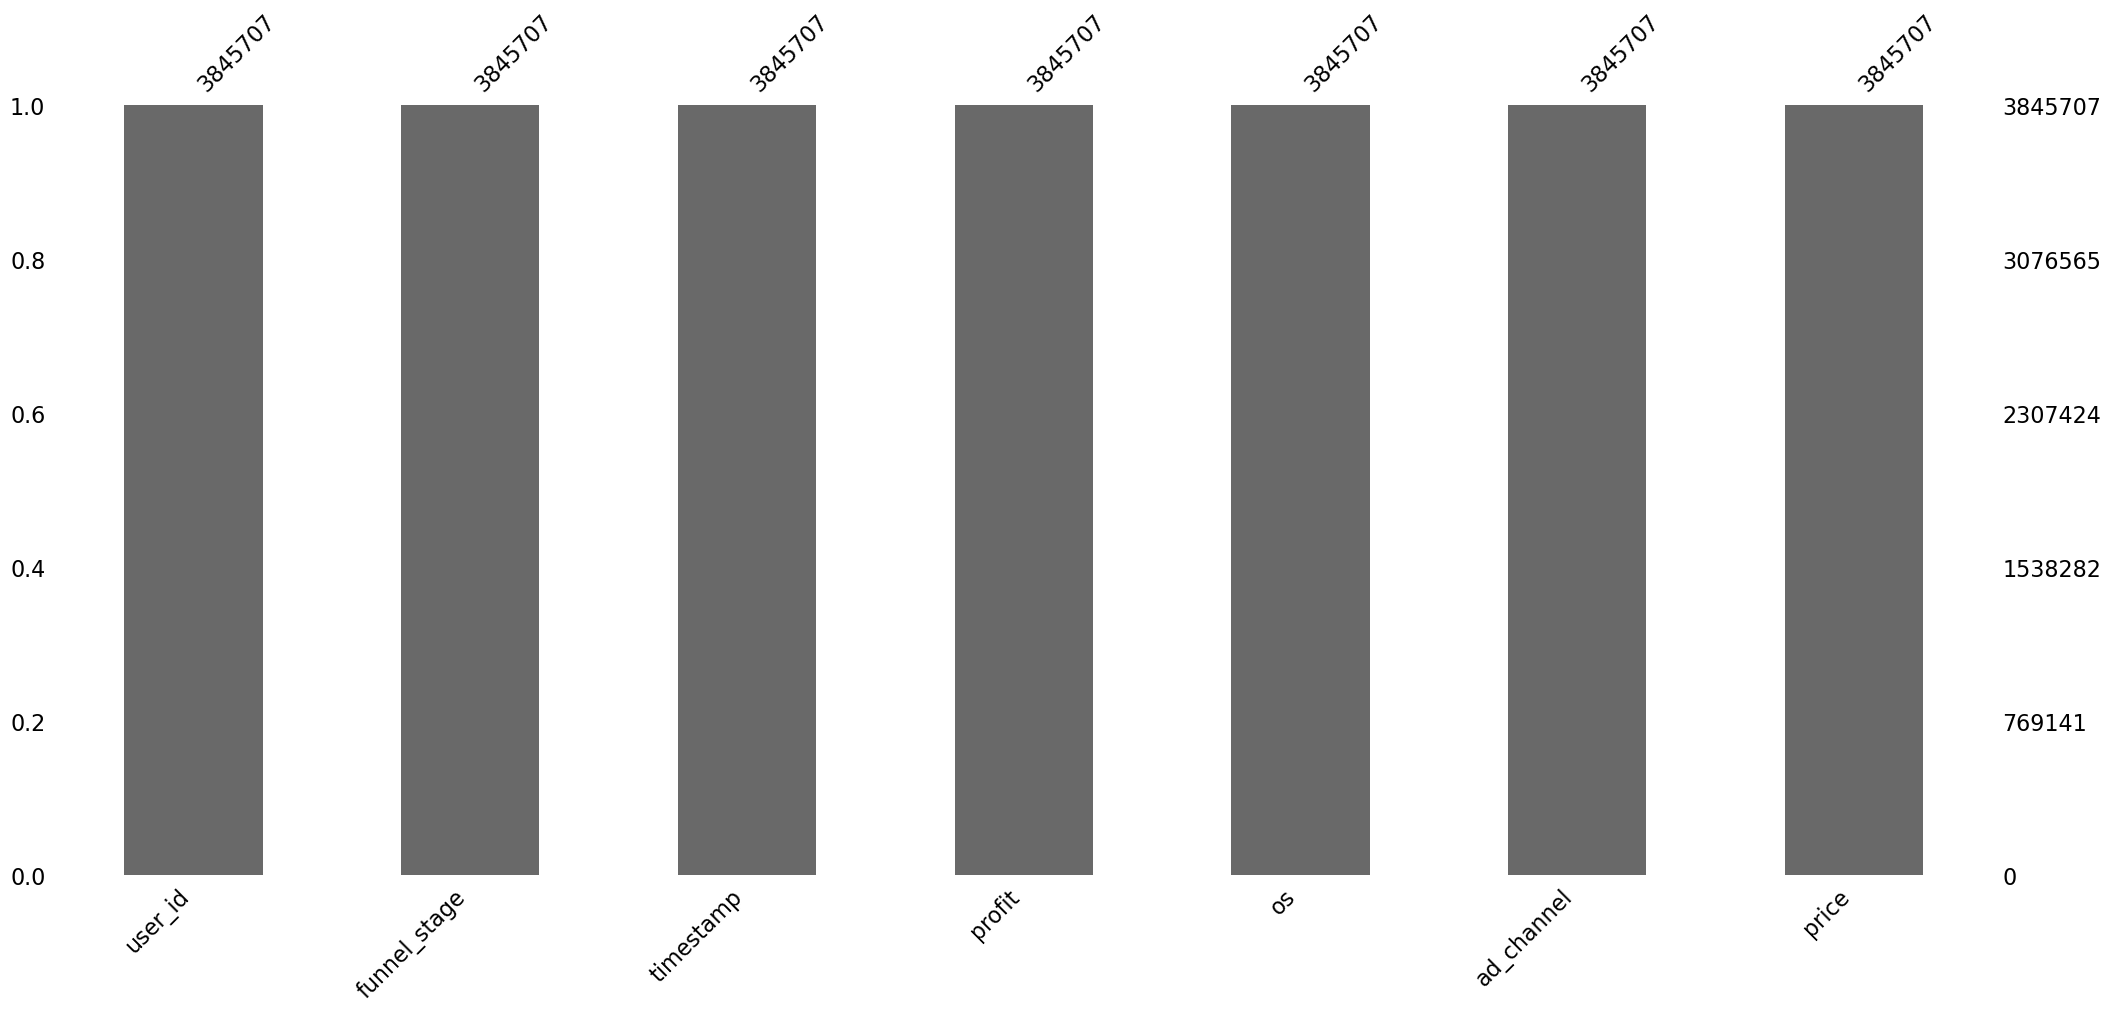

In [15]:
msno.bar(final_df)

In [16]:
final_df['funnel_stage'].unique()

array(['INTEREST', 'purchase', 'consideration', 'INTENT', 'PURCHASE',
       'intent', 'interest', 'CONSIDERATION'], dtype=object)

In [17]:
final_df['funnel_stage'] = final_df['funnel_stage'].str.lower()

In [18]:
final_df['funnel_stage'].unique()

array(['interest', 'purchase', 'consideration', 'intent'], dtype=object)

In [98]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3845707 entries, 0 to 3845706
Data columns (total 7 columns):
 #   Column        Dtype   
---  ------        -----   
 0   user_id       int64   
 1   funnel_stage  category
 2   timestamp     int64   
 3   profit        float64 
 4   os            object  
 5   ad_channel    object  
 6   price         float64 
dtypes: category(1), float64(2), int64(2), object(2)
memory usage: 179.7+ MB


Посчитайте, сколько уникальных пользователей пришло по каждому рекламному каналу в разрезе этапов воронки продаж. Посмотрите на результаты и подумайте, не кажутся ли они вам странными. Не забывайте о последовательности этапов и логике в воронке продаж.

Описание этапов воронки:

awareness — осведомлённость (факт показа рекламы); в нашей таблице этот этап воронки пропущен;
interest — интерес (клик по рекламному баннеру и переход на сайт);
consideration — рассмотрение к покупке (выбор планов подписки, хождение по продуктовым страницам);
intent — намерение купить (выбор плана, заявка на обратную связь, регистрация);
purchase — покупка.

In [20]:
funnel_stage_order = ['interest', 'consideration', 'intent', 'purchase'] 
funnel_stage_dtype = CategoricalDtype(categories=funnel_stage_order, ordered=True)
final_df['funnel_stage'] = final_df['funnel_stage'].astype(funnel_stage_dtype)

In [21]:
final_df.drop(columns=['profit','os', 'timestamp','price']).groupby(['ad_channel','funnel_stage']).count()

user_id
ad_channel      funnel_stage          
banner          interest        487948
                consideration    47541
                intent           39992
                purchase           688
native          interest        102953
                consideration    12597
                intent            1988
                purchase            37
organic_traffic interest        431003
                consideration    53592
                intent           46447
                purchase           542
other           interest         18859
                consideration     1813
                intent            1873
                purchase            43
partner_network interest        334837
                consideration    24721
                intent           27422
                purchase           450
rich            interest         54440
                consideration     4657
                intent            4969
                purchase            22
search          interest       1196169
                consideration   134305
                intent          157641
                purchase          3090
video           interest        593604
                consideration    60880
                intent             579
                purchase             5

Странно, что в некоторых каналах (other, partner_network, rich и search	)	 consideration < intent. Предполагается, что с переходом к каждому следующему этапу количество людей в воронке уменьшается.

In [65]:
#Группировка данных по столбцам 'timestamp' и 'user_id', и подсчет количества действий.
#Т.е.смотрим, сколько действий в конкретный момент времени совершил конкретный пользователь.
df_actions_per_timestamp_per_user = final_df.groupby(['timestamp', 'user_id']).size()

In [66]:
df_actions_per_timestamp_per_user

timestamp  user_id
150000     26717      1
           108759     1
           111649     1
           143856     1
           219687     1
                     ..
224682     929180     1
225430     1034498    1
225482     947521     1
225495     720354     1
225688     151184     1
Length: 991900, dtype: int64

In [67]:
max_actions = df_actions_per_timestamp_per_user.max()
print("Максимальное количество действий в один момент времени:", max_actions)

Максимальное количество действий в один момент времени: 599


In [76]:
df_actions_per_timestamp_per_user.unique()

array([  1, 591, 579, 502, 576, 528, 522, 503, 553, 568, 515, 525, 571,
       501, 504, 575, 551, 518, 573, 526, 559, 523, 558, 577, 511, 545,
       569, 554, 539, 550, 535, 533, 547, 583, 507, 532, 508, 593, 557,
       536, 594, 567, 582, 599, 546, 578, 580, 585, 549, 510, 552, 542,
       587, 595, 584, 521, 588, 572, 596, 590, 544, 534, 514, 529, 566,
       586, 598, 581, 556, 512, 589, 564, 516, 555, 560, 520, 562, 538,
       597, 561, 570, 592, 565, 499, 519, 548, 506, 505, 563, 509, 540,
       574, 537, 513, 531, 543, 517, 527, 524, 530, 541, 500,   2],
      dtype=int64)

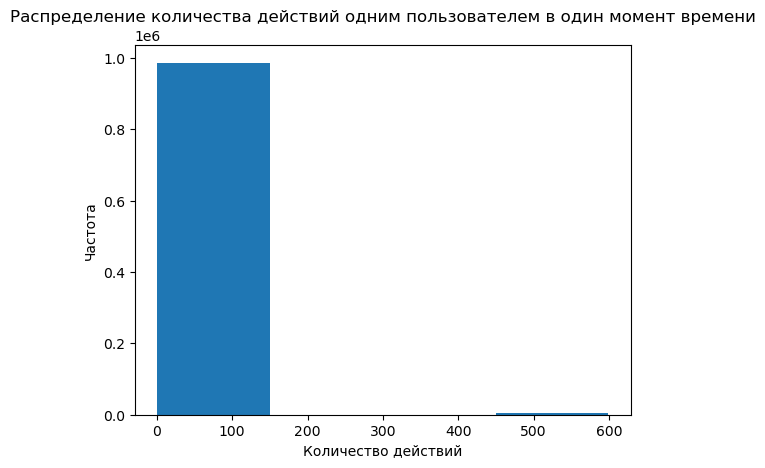

In [74]:
df_actions_per_timestamp_per_user.plot(kind='hist', bins=4)

plt.title('Распределение количества действий одним пользователем в один момент времени')
plt.xlabel('Количество действий')
plt.ylabel('Частота')

plt.show()

Вывод: все 'user_id', которые совершили более 2 действий в один момент времени - не живые люди, нужно их удалить

In [84]:
df_fraud_users = df_actions_per_timestamp_per_user[df_actions_per_timestamp_per_user.values>2]

In [85]:
df_fraud_users

timestamp  user_id
150029     910643     591
150074     851456     579
150081     151759     502
           524312     576
150111     208151     528
                     ... 
213008     824403     520
214121     368164     585
214849     780464     558
216517     253043     528
217701     153440     582
Length: 5203, dtype: int64

In [87]:
# Список всех уникальных 'user_id', которые совершили более 2 действий в один момент времени 
df_fraud_users.index.get_level_values('user_id').nunique()

4344

In [88]:
list_of_fraud_users_id = (df_fraud_users.index.get_level_values('user_id').unique()).tolist()
len(list_of_fraud_users_id)

4344

In [96]:
# Удаление строк, у которых значение в 'user_id' есть в списке list_of_fraud_users_id
clean_final_df = final_df[~final_df['user_id'].isin(list_of_fraud_users_id)]

In [97]:
clean_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 981498 entries, 0 to 3845706
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   user_id       981498 non-null  int64   
 1   funnel_stage  981498 non-null  category
 2   timestamp     981498 non-null  int64   
 3   profit        981498 non-null  float64 
 4   os            981498 non-null  object  
 5   ad_channel    981498 non-null  object  
 6   price         981498 non-null  float64 
dtypes: category(1), float64(2), int64(2), object(2)
memory usage: 53.4+ MB


In [99]:
clean_final_df.shape

(981498, 7)

In [104]:
#Группировка данных только по 'timestamp' и подсчет количества действий.
#Т.е.смотрим, сколько действий в конкретный момент времени совершили все пользователи.
df_actions_per_timestamp_all_users = clean_final_df.groupby('timestamp').size()

In [105]:
sorted(df_actions_per_timestamp_all_users.unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40]

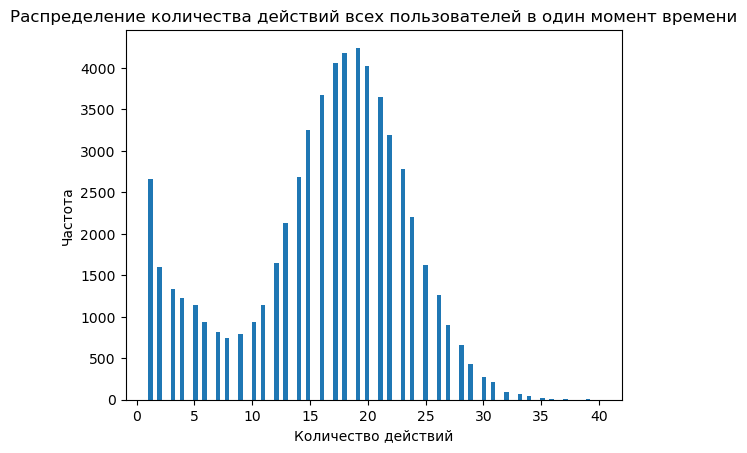

In [107]:
df_actions_per_timestamp_all_users.plot(kind='hist', bins=100)

plt.title('Распределение количества действий всех пользователей в один момент времени')
plt.xlabel('Количество действий')
plt.ylabel('Частота')

plt.show()

In [108]:
# Сохранить основной исправленный DataFrame в файл CSV
final_df.to_csv('D:/DO_NOT_REMOVE/Data_Analyst_Junior/7_11/Данные для кейса/funnel_info_2.csv', index=False) 

In [124]:
#Проверка на дубликаты
clean_final_df[clean_final_df.duplicated()].shape

(0, 7)

In [109]:
# Сохранить очищенный основной исправленный DataFrame в файл CSV
clean_final_df.to_csv('D:/DO_NOT_REMOVE/Data_Analyst_Junior/7_11/Данные для кейса/funnel_info_3.csv', index=False) 

In [114]:
percent_of_fraud_users = len(list_of_fraud_users_id)/ final_df['user_id'].nunique()*100
print(f'Процент фродовых пользователей от общего числа составлял {percent_of_fraud_users:.4f}%')

Процент фродовых пользователей от общего числа составлял 0.8169%


In [118]:
percent_of_fraud_records = 100 -(clean_final_df.shape[0]/final_df.shape[0]*100)
print(f'Процент фродовых записей от общего числа записей составлял {percent_of_fraud_records:.4f}%')

Процент фродовых записей от общего числа записей составлял 74.4781%


In [119]:
df_fraud_users = final_df[final_df['user_id'].isin(list_of_fraud_users_id)]
df_fraud_users

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
90,153440,intent,217701,0.0,Android,organic_traffic,0.0
91,153440,intent,217701,0.0,Android,organic_traffic,0.0
92,153440,intent,217701,0.0,iOS,organic_traffic,0.0
93,153440,intent,217701,0.0,iOS,organic_traffic,0.0
94,153440,intent,217701,0.0,iOS,organic_traffic,0.0
...,...,...,...,...,...,...,...
3845330,910643,interest,150029,0.0,Android,search,1.5
3845331,910643,interest,150029,0.0,iOS,search,1.5
3845332,910643,interest,150029,0.0,iOS,search,1.5
3845333,910643,interest,150029,0.0,iOS,search,1.5


In [120]:
# Сохранить DF с фродовыми данными в файл CSV
df_fraud_users.to_csv('D:/DO_NOT_REMOVE/Data_Analyst_Junior/7_11/Данные для кейса/df_fraud_data.csv', index=False) 